In [1]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
from datetime import datetime
from io import StringIO
import requests
import joblib

In [2]:

# Configuration
TICKER = "META"
API_KEY = "MAULMAZ7CKV4HWX9"
WINDOW_SIZE = 60
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# =============================================
# 1. Enhanced Data Fetching and Preparation
# =============================================

def fetch_and_preprocess_data():
    """Enhanced data fetching and preprocessing with additional features"""
    CACHE_FILE = f"alpha_vantage_data/{TICKER}_FULL_ENHANCED.csv"
    os.makedirs("alpha_vantage_data", exist_ok=True)
    
    if os.path.exists(CACHE_FILE):
        print("✅ Loading preprocessed data from cache")
        df = pd.read_csv(CACHE_FILE, parse_dates=['Date'])
        return df
    
    print("⏳ Downloading and preprocessing data...")
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={TICKER}&outputsize=full&datatype=csv&apikey={API_KEY}"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        df = pd.read_csv(StringIO(response.text))
        df = df.rename(columns={'timestamp': 'Date'})
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date')
        df = df[['Date', 'open', 'high', 'low', 'close', 'volume']]
        df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        
        # Enhanced Feature Engineering
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
        df['Daily_Return'] = df['Close'].pct_change()
        df['Volatility'] = df['Daily_Return'].rolling(window=10).std()
        
        # Bollinger Bands
        df['Upper_Bollinger'] = df['SMA_20'] + (2 * df['Close'].rolling(window=20).std())
        df['Lower_Bollinger'] = df['SMA_20'] - (2 * df['Close'].rolling(window=20).std())
        
        # Enhanced RSI Calculation
        def calculate_RSI(series, period=14):
            delta = series.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
            RS = gain / loss
            return 100 - (100 / (1 + RS))
        
        df['RSI'] = calculate_RSI(df['Close'])
        
        # MACD with Signal Line
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_hist'] = df['MACD'] - df['MACD_signal']
        
        # Drop NA values and reset index
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)
        
        # Save processed data to cache
        df.to_csv(CACHE_FILE, index=False)
        print(f"💾 Saved enhanced dataset to {CACHE_FILE}")
        return df
        
    except Exception as e:
        print(f"❌ Error: {e}")
        raise

# Fetch and show data
df = fetch_and_preprocess_data()
print(f"\n📅 Data Range: {df['Date'].min()} to {df['Date'].max()}")
print(f"📊 Dataset Shape: {df.shape}")
display(df.head())

✅ Loading preprocessed data from cache

📅 Data Range: 2012-07-30 00:00:00 to 2025-05-08 00:00:00
📊 Dataset Shape: (3213, 18)


,Date,Open,High,Low,Close,Volume,SMA_20,SMA_50,EMA_12,EMA_26,Daily_Return,Volatility,Upper_Bollinger,Lower_Bollinger,RSI,MACD,MACD_signal,MACD_hist
0,2012-07-30,23.995,24.04,23.03,23.15,29285900,29.23780,29.838636,27.433268,28.958804,-0.023413,0.047743,34.169255,24.306345,15.733114,-1.525536,-0.894611,-0.630926
1,2012-07-31,23.370,23.37,21.61,21.71,56179400,28.78475,29.508200,26.552765,28.421856,-0.062203,0.049352,34.691542,22.877958,14.602446,-1.869091,-1.089507,-0.779584
2,2012-08-01,21.500,21.58,20.84,20.88,44604400,28.26875,29.245200,25.680032,27.863200,-0.038231,0.044581,35.028615,21.508885,13.890909,-2.183168,-1.308239,-0.874929
3,2012-08-02,20.770,20.84,19.82,20.04,56374500,27.69725,29.026000,24.812335,27.283703,-0.040230,0.043519,35.208463,20.186037,13.172414,-2.471369,-1.540865,-0.930504
4,2012-08-03,20.360,22.16,19.90,21.09,80647000,27.16525,28.807800,24.239668,26.824911,0.052395,0.051259,34.975085,19.355415,22.638623,-2.585243,-1.749740,-0.835502


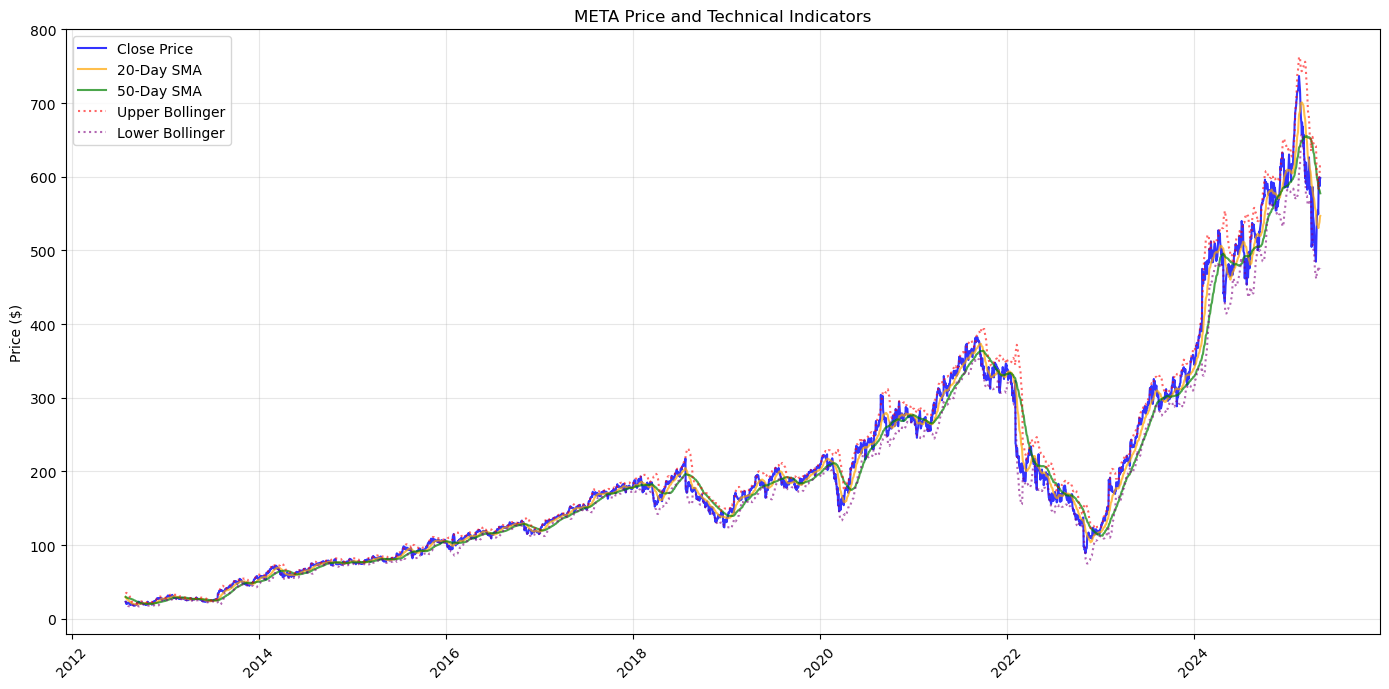

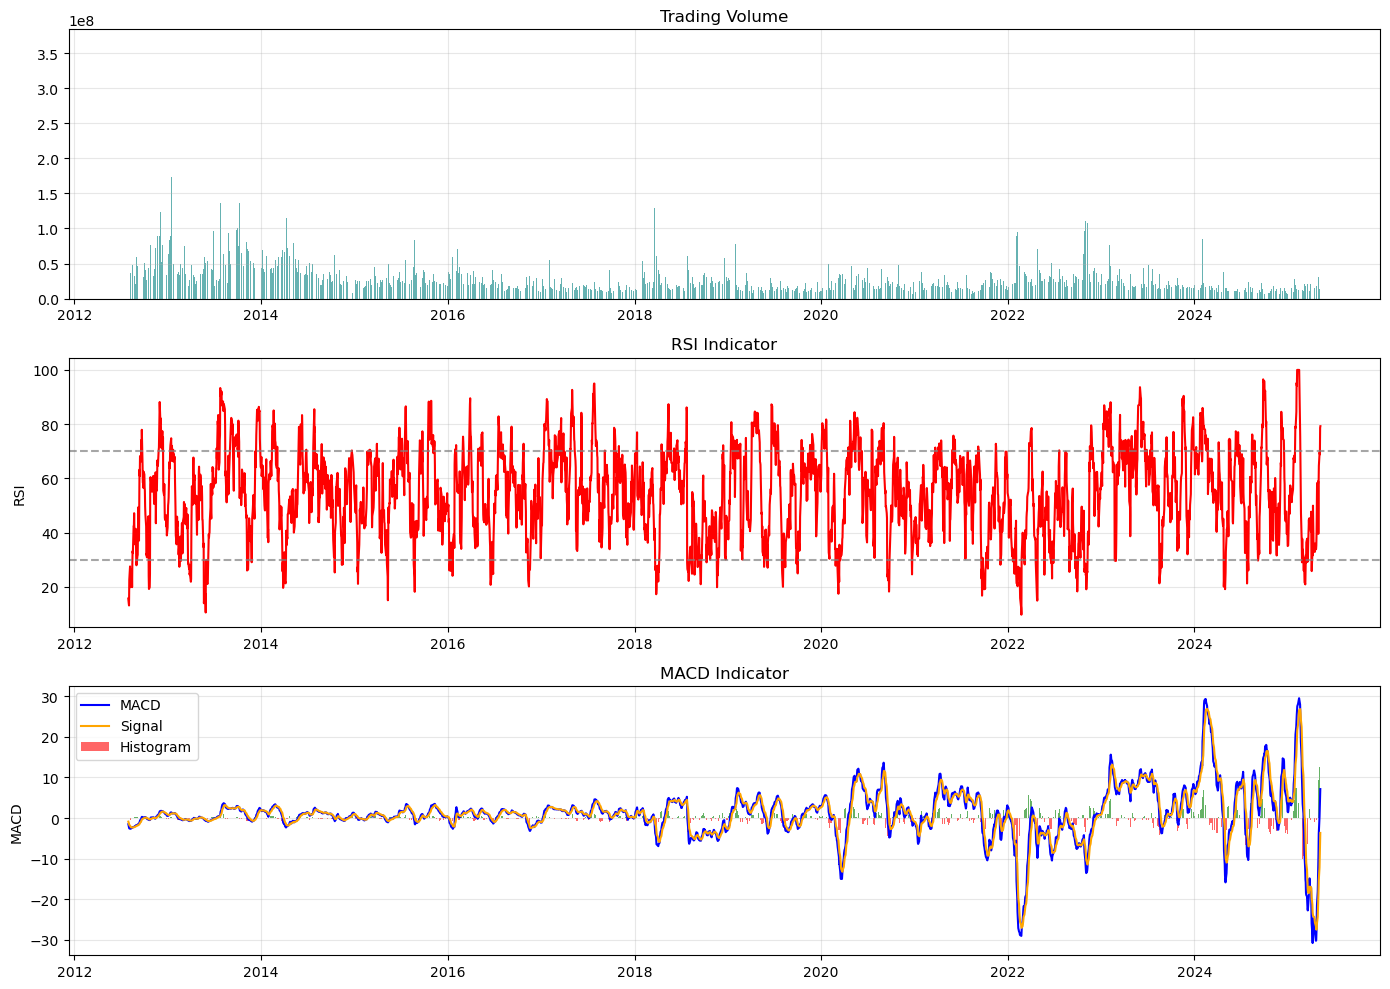

In [3]:
# =============================================
# 2. Enhanced Technical Indicators Visualization
# =============================================

# Plot Price and Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue', alpha=0.8)
plt.plot(df['Date'], df['SMA_20'], label='20-Day SMA', color='orange', alpha=0.7)
plt.plot(df['Date'], df['SMA_50'], label='50-Day SMA', color='green', alpha=0.7)
plt.plot(df['Date'], df['Upper_Bollinger'], label='Upper Bollinger', color='red', linestyle=':', alpha=0.6)
plt.plot(df['Date'], df['Lower_Bollinger'], label='Lower Bollinger', color='purple', linestyle=':', alpha=0.6)
plt.title(f"{TICKER} Price and Technical Indicators")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Volume and Indicators
plt.figure(figsize=(14, 10))

# Volume
plt.subplot(3, 1, 1)
plt.bar(df['Date'], df['Volume'], color='teal', alpha=0.6)
plt.title("Trading Volume")
plt.grid(True, alpha=0.3)

# RSI
plt.subplot(3, 1, 2)
plt.plot(df['Date'], df['RSI'], label='RSI (14)', color='red')
plt.axhline(70, linestyle='--', color='gray', alpha=0.7)
plt.axhline(30, linestyle='--', color='gray', alpha=0.7)
plt.title("RSI Indicator")
plt.ylabel("RSI")
plt.grid(True, alpha=0.3)

# MACD
plt.subplot(3, 1, 3)
plt.plot(df['Date'], df['MACD'], label='MACD', color='blue')
plt.plot(df['Date'], df['MACD_signal'], label='Signal', color='orange')
plt.bar(df['Date'], df['MACD_hist'], label='Histogram', color=np.where(df['MACD_hist'] >= 0, 'green', 'red'), alpha=0.6)
plt.title("MACD Indicator")
plt.ylabel("MACD")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# =============================================
# 3. Advanced Data Scaling
# =============================================

def scale_features(df):
    """Advanced feature scaling with different scalers for different features"""
    scaled_df = df.copy()
    
    # Price features scaling (avoid extremes)
    price_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    price_cols = ['Close', 'SMA_20', 'SMA_50', 'Upper_Bollinger', 'Lower_Bollinger']
    scaled_df[price_cols] = price_scaler.fit_transform(df[price_cols])
    
    # Volume scaling (log transform + robust scaling)
    scaled_df['Volume'] = np.log1p(df['Volume'])
    volume_scaler = RobustScaler()
    scaled_df['Volume'] = volume_scaler.fit_transform(df[['Volume']])
    
    # Indicator scaling (-1 to 1 range)
    indicator_scaler = MinMaxScaler(feature_range=(-1, 1))
    indicator_cols = ['RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Volatility']
    scaled_df[indicator_cols] = indicator_scaler.fit_transform(df[indicator_cols])
    
    # Save scalers
    joblib.dump(price_scaler, f'{MODEL_DIR}/price_scaler.save')
    joblib.dump(volume_scaler, f'{MODEL_DIR}/volume_scaler.save')
    joblib.dump(indicator_scaler, f'{MODEL_DIR}/indicator_scaler.save')
    
    return scaled_df, price_scaler

scaled_df, price_scaler = scale_features(df)

In [9]:

# =============================================
# 4. Sequence Creation and Data Splitting
# =============================================

def create_sequences(df, target, features, window_size=60):
    X, y = [], []
    for i in range(window_size, len(df)):
        # df.loc accepts the feature‑list of column names
        seq = df.loc[i-window_size:i-1, features].values  
        X.append(seq)
        y.append(target[i])
    return np.array(X), np.array(y)





# Prepare datasets
features = ['Close', 'Volume', 'SMA_50', 'RSI', 'MACD', 'MACD_hist', 'Volatility']
target = scaled_df['Close'].values



# now pass the DataFrame, not its .values
X, y = create_sequences(scaled_df, scaled_df['Close'].values, features, WINDOW_SIZE)


# Split into train/test
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
dates_test = df['Date'].iloc[WINDOW_SIZE + train_size:].values

print(f"\n🔍 Data Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


🔍 Data Shapes:
X_train: (2522, 60, 7), y_train: (2522,)
X_test: (631, 60, 7), y_test: (631,)


In [13]:
# =============================================
# 5. Enhanced LSTM Model Architecture
# =============================================

def build_lstm_model(input_shape):
    """Build enhanced LSTM model with regularization"""
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape,
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(64, return_sequences=True,
             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(32),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.Huber(),  # Fixed here
                  metrics=['mae', 'mse'])
    
    return model

model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,825 (522.75 KB)

 Trainable params: 133,441 (521.25 KB)

 Non-trainable params: 384 (1.50 KB)


🏋️ Training model...
Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1.3758 - mae: 0.1684 - mse: 0.0558

71/71 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - loss: 1.3701 - mae: 0.1675 - mse: 0.0553 - val_loss: 0.3755 - val_mae: 0.2197 - val_mse: 0.0516 - learning_rate: 0.0010
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2394 - mae: 0.0568 - mse: 0.0057

71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.2384 - mae: 0.0567 - mse: 0.0057 - val_loss: 0.0816 - val_mae: 0.2349 - val_mse: 0.0603 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0367 - mae: 0.0437 - mse: 0.0033

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0365 - mae: 0.0437 - mse: 0.0033 - val_loss: 0.0366 - val_mae: 0.2210 - val_mse: 0.0547 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0084 - mae: 0.0438 - mse: 0.0032

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0084 - mae: 0.0437 - mse: 0.0032 - val_loss: 0.0264 - val_mae: 0.2090 - val_mse: 0.0478 - learning_rate: 0.0010
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0029 - mae: 0.0331 - mse: 0.0018

71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 0.0029 - mae: 0.0331 - mse: 0.0018 - val_loss: 0.0171 - val_mae: 0.1683 - val_mse: 0.0321 - learning_rate: 0.0010
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0017 - mae: 0.0310 - mse: 0.0016

71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0017 - mae: 0.0310 - mse: 0.0016 - val_loss: 0.0138 - val_mae: 0.1518 - val_mse: 0.0264 - learning_rate: 0.0010
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.0012 - mae: 0.0280 - mse: 0.0013

71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0012 - mae: 0.0280 - mse: 0.0013 - val_loss: 0.0129 - val_mae: 0.1485 - val_mse: 0.0250 - learning_rate: 0.0010
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0012 - mae: 0.0294 - mse: 0.0015

71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0012 - mae: 0.0295 - mse: 0.0015 - val_loss: 0.0081 - val_mae: 0.1080 - val_mse: 0.0156 - learning_rate: 0.0010
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 9.8889e-04 - mae: 0.0278 - mse: 0.0013 - val_loss: 0.0083 - val_mae: 0.1154 - val_mse: 0.0160 - learning_rate: 0.0010
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 7.0785e-04 - mae: 0.0238 - mse: 0.0010 - val_loss: 0.0115 - val_mae: 0.1363 - val_mse: 0.0216 - learning_rate: 0.0010
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0013 - mae: 0.0278 - mse: 0.0015

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0013 - mae: 0.0277 - mse: 0.0014 - val_loss: 0.0039 - val_mae: 0.0728 - val_mse: 0.0074 - learning_rate: 0.0010
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0013 - mae: 0.0312 - mse: 0.0017

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0013 - mae: 0.0312 - mse: 0.0017 - val_loss: 0.0013 - val_mae: 0.0372 - val_mse: 0.0019 - learning_rate: 0.0010
Epoch 13/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 7.7254e-04 - mae: 0.0252 - mse: 0.0010 - val_loss: 0.0016 - val_mae: 0.0363 - val_mse: 0.0029 - learning_rate: 0.0010
Epoch 14/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 5.3483e-04 - mae: 0.0219 - mse: 7.8749e-04 - val_loss: 0.0018 - val_mae: 0.0479 - val_mse: 0.0032 - learning_rate: 0.0010
Epoch 15/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 6.8565e-04 - mae: 0.0237 - mse: 9.8518e-04

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 6.8643e-04 - mae: 0.0237 - mse: 9.8554e-04 - val_loss: 5.4565e-04 - val_mae: 0.0209 - val_mse: 7.2777e-04 - learning_rate: 0.0010
Epoch 16/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 6.8813e-04 - mae: 0.0244 - mse: 0.0010 - val_loss: 9.6670e-04 - val_mae: 0.0325 - val_mse: 0.0016 - learning_rate: 0.0010
Epoch 17/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 5.0570e-04 - mae: 0.0211 - mse: 7.5129e-04 - val_loss: 0.0012 - val_mae: 0.0389 - val_mse: 0.0022 - learning_rate: 0.0010
Epoch 18/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 6.7590e-04 - mae: 0.0242 - mse: 0.0010

71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 6.7550e-04 - mae: 0.0242 - mse: 0.0010 - val_loss: 5.2521e-04 - val_mae: 0.0230 - val_mse: 7.8708e-04 - learning_rate: 0.0010
Epoch 19/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 5.4082e-04 - mae: 0.0218 - mse: 8.3580e-04 - val_loss: 0.0041 - val_mae: 0.0770 - val_mse: 0.0078 - learning_rate: 0.0010
Epoch 20/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 7.5946e-04 - mae: 0.0246 - mse: 0.0011 - val_loss: 5.5649e-04 - val_mae: 0.0231 - val_mse: 8.2326e-04 - learning_rate: 0.0010
Epoch 21/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 4.2012e-04 - mae: 0.0187 - mse: 5.8272e-04 - val_loss: 8.8771e-04 - val_mae: 0.0344 - val_mse: 0.0016 - learning_rate: 5.0000e-04
Epoch 22/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 3.6067e-04 - mae: 0.0177 - mse: 5.3591e-04 - val_loss: 0.0011 - val_mae: 0.0383 - val_mse: 0.0020 - learning_rate: 5.0000e-04
Epoch 23/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 4.3724e-04 - 

71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 4.3691e-04 - mae: 0.0198 - mse: 6.6367e-04 - val_loss: 4.9753e-04 - val_mae: 0.0237 - val_mse: 7.8882e-04 - learning_rate: 5.0000e-04
Epoch 24/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 3.4272e-04 - mae: 0.0172 - mse: 5.0351e-04 - val_loss: 0.0015 - val_mae: 0.0481 - val_mse: 0.0029 - learning_rate: 5.0000e-04
Epoch 25/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 4.5761e-04 - mae: 0.0212 - mse: 7.2450e-04 - val_loss: 0.0021 - val_mae: 0.0550 - val_mse: 0.0040 - learning_rate: 5.0000e-04
Epoch 26/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 4.5009e-04 - mae: 0.0193 - mse: 6.4772e-04 - val_loss: 0.0023 - val_mae: 0.0606 - val_mse: 0.0044 - learning_rate: 2.5000e-04
Epoch 27/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 3.4585e-04 - mae: 0.0176 - mse: 5.0879e-04

71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - loss: 3.4566e-04 - mae: 0.0176 - mse: 5.0849e-04 - val_loss: 4.7088e-04 - val_mae: 0.0215 - val_mse: 7.7323e-04 - learning_rate: 2.5000e-04
Epoch 28/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 2.9795e-04 - mae: 0.0156 - mse: 4.3488e-04 - val_loss: 5.7768e-04 - val_mae: 0.0267 - val_mse: 0.0010 - learning_rate: 2.5000e-04
Epoch 29/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 2.7969e-04 - mae: 0.0154 - mse: 4.1167e-04 - val_loss: 7.4610e-04 - val_mae: 0.0321 - val_mse: 0.0013 - learning_rate: 2.5000e-04
Epoch 30/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 3.0572e-04 - mae: 0.0165 - mse: 4.7278e-04 - val_loss: 5.8926e-04 - val_mae: 0.0264 - val_mse: 0.0010 - learning_rate: 2.5000e-04
Epoch 31/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3.2402e-04 - mae: 0.0174 - mse: 5.1263e-04

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 3.2394e-04 - mae: 0.0174 - mse: 5.1248e-04 - val_loss: 4.1767e-04 - val_mae: 0.0189 - val_mse: 6.9976e-04 - learning_rate: 1.2500e-04
Epoch 32/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.6911e-04 - mae: 0.0156 - mse: 4.1008e-04

71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 2.6920e-04 - mae: 0.0157 - mse: 4.1029e-04 - val_loss: 3.9492e-04 - val_mae: 0.0200 - val_mse: 6.6499e-04 - learning_rate: 1.2500e-04
Epoch 33/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 2.8038e-04 - mae: 0.0158 - mse: 4.3875e-04 - val_loss: 5.1066e-04 - val_mae: 0.0257 - val_mse: 8.9714e-04 - learning_rate: 1.2500e-04
Epoch 34/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 2.5864e-04 - mae: 0.0160 - mse: 3.9909e-04 - val_loss: 4.6014e-04 - val_mae: 0.0212 - val_mse: 8.0656e-04 - learning_rate: 1.2500e-04
Epoch 35/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 3.3012e-04 - mae: 0.0179 - mse: 5.4440e-04 - val_loss: 0.0010 - val_mae: 0.0404 - val_mse: 0.0019 - learning_rate: 1.2500e-04
Epoch 36/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 2.4164e-04 - mae: 0.0151 - mse: 3.6699e-04 - val_loss: 4.2165e-04 - val_mae: 0.0199 - val_mse: 7.3406e-04 - learning_rate: 1.2500e-04
Epoch 37/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0

71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - loss: 2.4725e-04 - mae: 0.0152 - mse: 3.8690e-04 - val_loss: 3.9411e-04 - val_mae: 0.0195 - val_mse: 6.7765e-04 - learning_rate: 6.2500e-05
Epoch 38/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 2.4032e-04 - mae: 0.0145 - mse: 3.7125e-04 - val_loss: 4.1957e-04 - val_mae: 0.0208 - val_mse: 7.3701e-04 - learning_rate: 6.2500e-05
Epoch 39/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 2.7916e-04 - mae: 0.0156 - mse: 4.5348e-04 - val_loss: 4.2419e-04 - val_mae: 0.0207 - val_mse: 7.4614e-04 - learning_rate: 6.2500e-05
Epoch 40/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 2.2990e-04 - mae: 0.0148 - mse: 3.5870e-04 - val_loss: 4.0985e-04 - val_mae: 0.0199 - val_mse: 7.2050e-04 - learning_rate: 6.2500e-05
Epoch 41/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 2.2373e-04 - mae: 0.0141 - mse: 3.4838e-04 - val_loss: 5.9670e-04 - val_mae: 0.0283 - val_mse: 0.0011 - learning_rate: 6.2500e-05
Epoch 42/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 6

71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 2.0510e-04 - mae: 0.0133 - mse: 3.1907e-04 - val_loss: 3.8339e-04 - val_mae: 0.0191 - val_mse: 6.7418e-04 - learning_rate: 1.5625e-05
Epoch 50/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 2.4132e-04 - mae: 0.0150 - mse: 3.9135e-04 - val_loss: 4.0377e-04 - val_mae: 0.0205 - val_mse: 7.1800e-04 - learning_rate: 1.5625e-05
Epoch 51/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 2.1689e-04 - mae: 0.0141 - mse: 3.4409e-04 - val_loss: 4.3109e-04 - val_mae: 0.0221 - val_mse: 7.7241e-04 - learning_rate: 1.5625e-05
Epoch 52/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 2.5921e-04 - mae: 0.0157 - mse: 4.2839e-04 - val_loss: 4.3960e-04 - val_mae: 0.0224 - val_mse: 7.9089e-04 - learning_rate: 7.8125e-06
Epoch 53/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 2.3413e-04 - mae: 0.0144 - mse: 3.7962e-04 - val_loss: 3.8387e-04 - val_mae: 0.0196 - val_mse: 6.7854e-04 - learning_rate: 7.8125e-06
Epoch 54/100
71/71 ━━━━━━━━━━━━━━

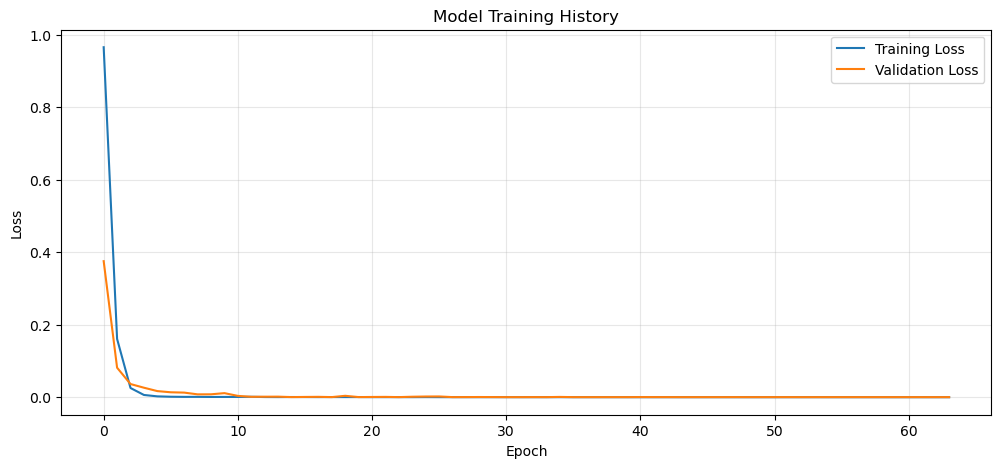

In [14]:

# =============================================
# 6. Training with Callbacks
# =============================================

print("\n🏋️ Training model...")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint(filepath=f"{MODEL_DIR}/best_model.h5", 
                   monitor='val_loss',
                   save_best_only=True)
]

history = model.fit(X_train, y_train,
                   epochs=100,
                   batch_size=32,
                   validation_split=0.1,
                   callbacks=callbacks,
                   verbose=1)

# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


📊 Evaluating model performance...
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


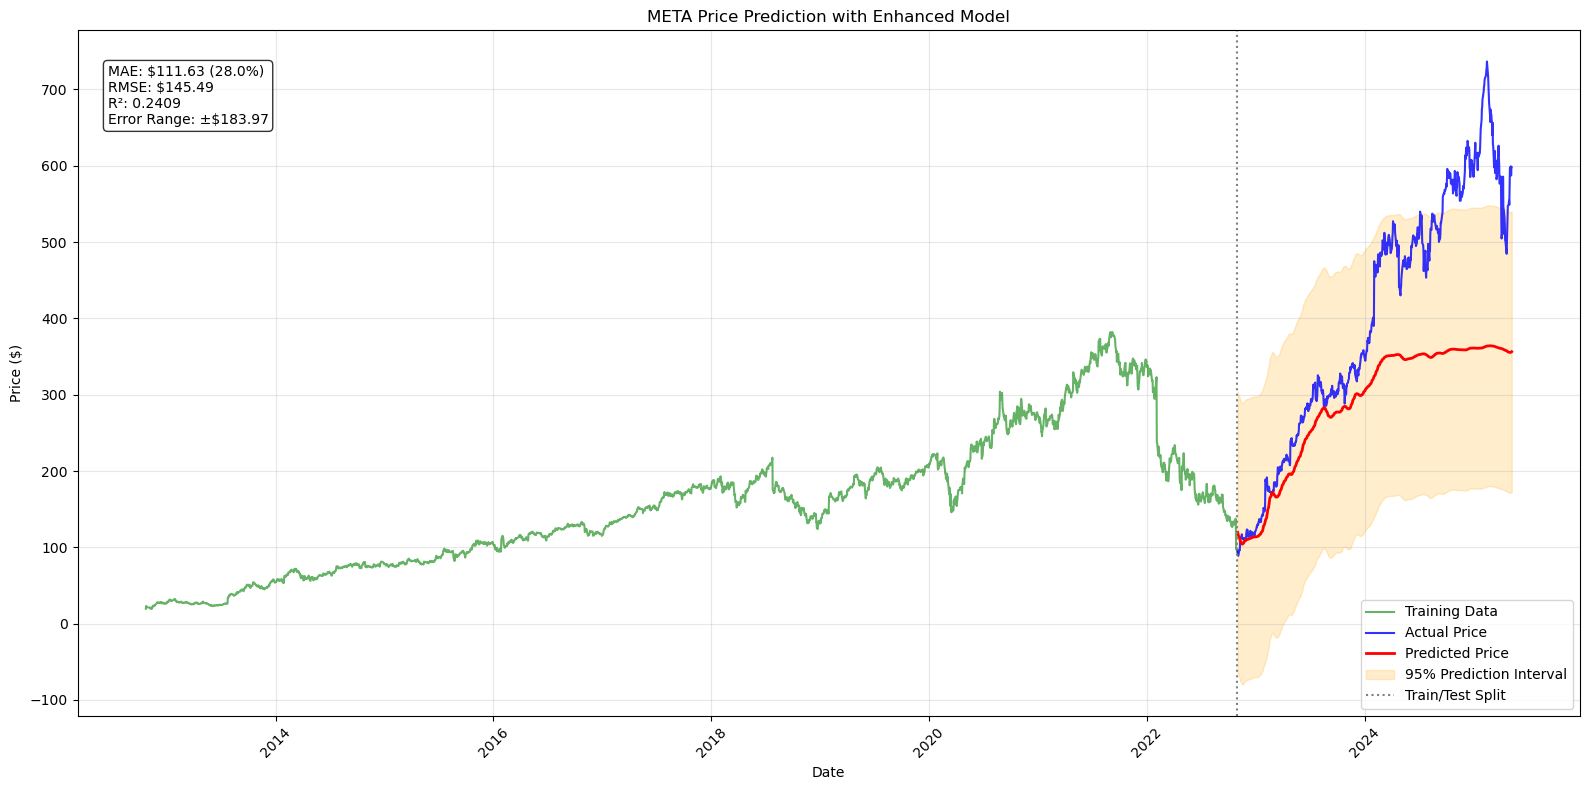

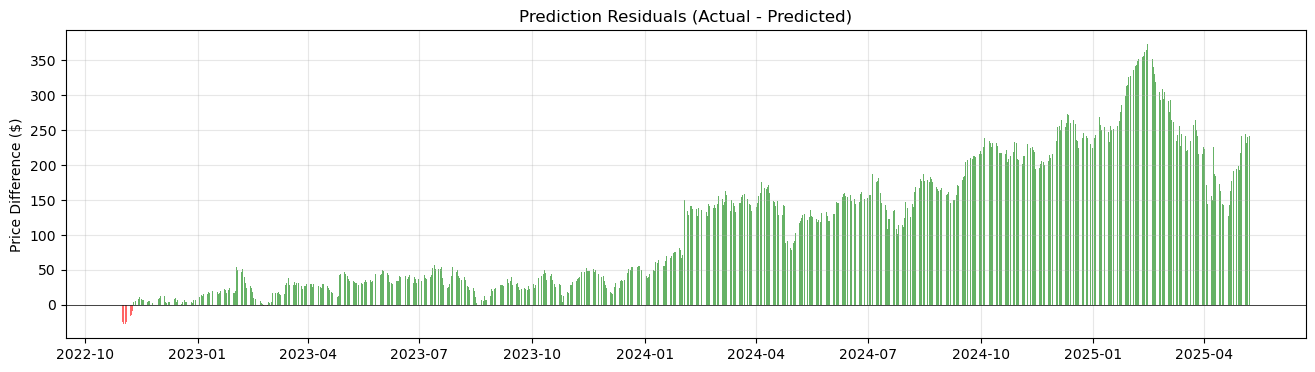

In [16]:

# =============================================
# 7. Evaluation and Visualization
# =============================================

print("\n📊 Evaluating model performance...")

# Make predictions
pred_scaled = model.predict(X_test)

# Inverse transform predictions
dummy = np.zeros((len(pred_scaled), len(price_scaler.feature_names_in_)))
dummy[:, 0] = pred_scaled[:, 0]
predicted = price_scaler.inverse_transform(dummy)[:, 0]

# Inverse transform actual values
dummy_true = np.zeros((len(y_test), len(price_scaler.feature_names_in_)))
dummy_true[:, 0] = y_test
actual = price_scaler.inverse_transform(dummy_true)[:, 0]

# Calculate metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
r_squared = r2_score(actual, predicted)
std_residuals = np.std(actual - predicted)
prediction_interval = 1.96 * std_residuals

# Enhanced Visualization
plt.figure(figsize=(16, 8))

# Get training dates and values
dates_train = df['Date'].iloc[WINDOW_SIZE:WINDOW_SIZE + train_size].values
dummy_train = np.zeros((len(y_train), len(price_scaler.feature_names_in_)))
dummy_train[:, 0] = y_train
train_actual = price_scaler.inverse_transform(dummy_train)[:, 0]

# Plot training data
plt.plot(dates_train, train_actual, label='Training Data', color='green', alpha=0.6)

# Plot test data
plt.plot(dates_test, actual, label='Actual Price', color='blue', alpha=0.8)
plt.plot(dates_test, predicted, label='Predicted Price', color='red', linewidth=2)

# Prediction interval
plt.fill_between(dates_test, 
                predicted - prediction_interval, 
                predicted + prediction_interval,
                color='orange', alpha=0.2, label='95% Prediction Interval')

# Train/test split line
split_date = dates_train[-1]
plt.axvline(x=split_date, color='gray', linestyle=':', label='Train/Test Split')

# Metrics display
textstr = '\n'.join((
    f'MAE: ${mae:.2f} ({100*mae/np.mean(actual):.1f}%)',
    f'RMSE: ${rmse:.2f}',
    f'R²: {r_squared:.4f}',
    f'Error Range: ±${prediction_interval:.2f}'))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
        verticalalignment='top', bbox=props)

plt.title(f"{TICKER} Price Prediction with Enhanced Model")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = actual - predicted
plt.figure(figsize=(16, 4))
plt.bar(dates_test, residuals, color=np.where(residuals >= 0, 'green', 'red'), alpha=0.6)
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.title('Prediction Residuals (Actual - Predicted)')
plt.ylabel('Price Difference ($)')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:

# Confidence Report
confidence_report = f"""
**📈 Enhanced Prediction Confidence Analysis**

1. Error Metrics:
   - Mean Absolute Error (MAE): ${mae:.2f} ({100*mae/np.mean(actual):.1f}% of average price)
   - Root Mean Squared Error (RMSE): ${rmse:.2f}
   - Standard Deviation of Errors: ${std_residuals:.2f}

2. Prediction Intervals (95% confidence):
   - Typical Error Range: ±${prediction_interval:.2f}

3. Model Accuracy:
   - R² Score: {r_squared:.4f}
   - The model explains {100*r_squared:.1f}% of price variability

💾 Model saved to: {MODEL_DIR}/best_model.h5
"""
print(confidence_report)

# Example prediction
next_day_pred = 150.00  # Example value
print(f"\nExample for ${next_day_pred:.2f} prediction:")
print(f"95% confidence range: ${next_day_pred-prediction_interval:.2f} to ${next_day_pred+prediction_interval:.2f}")
print(f"Expected accuracy: ±{100*mae/np.mean(actual):.1f}% (${mae:.2f})")


**📈 Enhanced Prediction Confidence Analysis**

1. Error Metrics:
   - Mean Absolute Error (MAE): $111.63 (28.0% of average price)
   - Root Mean Squared Error (RMSE): $145.49
   - Standard Deviation of Errors: $93.86

2. Prediction Intervals (95% confidence):
   - Typical Error Range: ±$183.97

3. Model Accuracy:
   - R² Score: 0.2409
   - The model explains 24.1% of price variability

💾 Model saved to: saved_models/best_model.h5


Example for $150.00 prediction:
95% confidence range: $-33.97 to $333.97
Expected accuracy: ±28.0% ($111.63)
